In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo_wmap9
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as consts
from astropy import units

sys.path.append('..')
from env_config import DATA_PATH
from utils import *
from data import *
from plotting import *
from evaluation import *

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

sns.set(style='whitegrid')
sns.set_palette('cubehelix')

# Read data

In [ ]:
# Get SDSS catalog quasars
columns = ['RA', 'DEC', 'Z', 'Z_ERR', 'ZWARNING', 'r_PSFMAG']
sdss_qso_ctlg = read_fits_to_pandas(os.path.join(DATA_PATH, 'SDSS/DR14Q_v4_4.fits'), columns=columns)
print(sdss_qso_ctlg.shape)
sdss_qso_ctlg = clean_sdss(sdss_qso_ctlg)

# Probably null values
sdss_qso_ctlg = sdss_qso_ctlg.loc[sdss_qso_ctlg['r_PSFMAG'] > 0]
print(sdss_qso_ctlg.shape)

In [ ]:
# Get KiDSxSDSS quasars (for magnitude measurement)
kids_x_sdss = process_kids(os.path.join(DATA_PATH, 'KiDS/DR4/KiDS.DR4.x.SDSS.DR14.fits'), sdss_cleaning=True,
                           columns=COLUMNS_KIDS_ALL+COLUMNS_SDSS)
kids_x_sdss_qso = kids_x_sdss.loc[kids_x_sdss['CLASS'] == 'QSO']
kids_x_sdss_qso.shape

## Get and save V/V_max weights

In [81]:
m_max = 22.7
sdss_qso_ctlg['v_weight'] = get_v_max_weights(sdss_qso_ctlg['r_PSFMAG'], sdss_qso_ctlg['Z'], m_max=m_max, processes=24)

100%|██████████| 446136/446136 [10:40<00:00, 696.58it/s]


In [ ]:
sdss_qso_ctlg.to_csv(os.path.join(DATA_PATH, 'SDSS/DR14Q_v4_4_v-weights_m-max-22-7.fits'))

## Read v_weights

In [76]:
qso_sdss = pd.read_csv(os.path.join(DATA_PATH, 'SDSS/DR14Q_v4_4_v-weights_r-max-22-7.fits'))

In [77]:
qso_sdss['v_weight'].mean()

0.363130868750847

# Number counts

In [4]:
eboss_sky_coverage = 10000  # deg^2

In [5]:
# eBOSS - r magnitude
eboss_r_arr = np.arange(16, 24.1, 0.5)
eboss_lede_r_counts_arr = [
    88,
    227,
    630,
    1830,
    5404,
    15314,
    38401,
    80354,
    139813,
    209907,
    286955,
    373634,
    475834,
    600426,
    754965,
    948101,
    1190284,
]
eboss_r_counts_arr = [
    73,
    194,
    544,
    1644,
    5185,
    15669,
    40203,
    82311,
    137438,
    203490,
    280474,
    376490,
    497420,
    649495,
    841448,
    1283562,
    1290504,
]

In [6]:
# eBOSS - g magnitude
# https://www.aanda.org/articles/aa/full_html/2016/03/aa27392-15/aa27392-15.html#S7
eboss_g_arr = np.arange(16, 25.1, 0.5)
eboss_g_counts_arr = [
    38,
    100,
    272,
    806,
    2599,
    8660,
    26413,
    63722,
    113766,
    177430,
    247474,
    331487,
    436402,
    567480,
    733442,
    943438,
    1210506,
    1250506,
    1282533,
]

In [7]:
# SDSS - g magnitude
# https://iopscience.iop.org/article/10.1086/431358/pdf
# Roughly taken from a figure
sdss_g_arr = np.arange(17.5, 21.1, 0.5)
sdss_g_counts_arr = [
    0.2,
    0.6,
    1.5,
    3,
    7,
    10,
    15,
    20,
]

In [6]:
def plot_number_counts(magnitude_arr, counts_arr, sky_coverage, linear_data, magnitude, label=None):
    counts_sum_arr = [sum(counts_arr[:i+1]) for i in range(len(counts_arr))]
        
    density_arr = np.array(counts_sum_arr) / sky_coverage
    fig, ax = plt.subplots()
    sns.scatterplot(magnitude_arr, density_arr, label=label)
    
    plot_linear_data(linear_data, annotations=False)
    
    plt.xlabel('${}$ magnitude'.format(magnitude))
    plt.ylabel(r'surface density (≤ m) [N / deg$^2$]')
    plt.yscale('log')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[handles[-1]] + handles[0:-1], labels=[labels[-1]] + labels[0:-1], loc='lower right',
              framealpha=1.0)

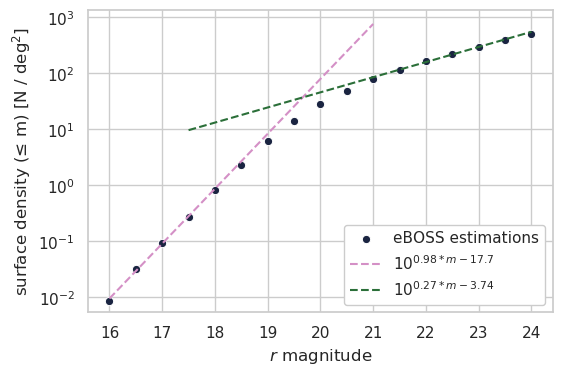

In [7]:
linear_data = [
    (0.98, 17.7, (16, 21)),
    (0.27, 3.74, (17.5, 24)),
]
plot_number_counts(eboss_r_arr, eboss_lede_r_counts_arr, eboss_sky_coverage, linear_data, magnitude='r', label='eBOSS estimations')

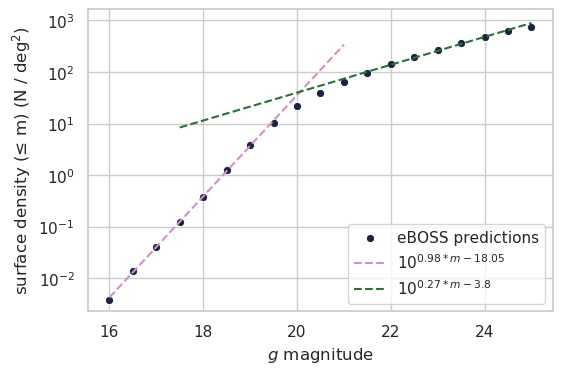

In [60]:
linear_data = [
    (0.98, 18.05, (16, 21)),
    (0.27, 3.8, (17.5, 25)),
]
plot_number_counts(eboss_g_arr, eboss_g_counts_arr, eboss_sky_coverage, linear_data, magnitude='g', label='eBOSS predictions')

$QSO_{spec}$ SDSS area: 10312.19 deg^2


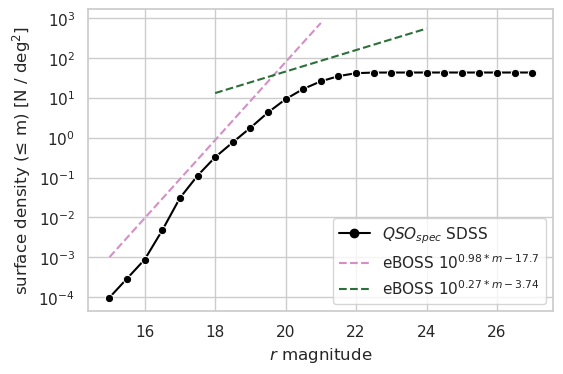

In [79]:
data_dict = {
    '$QSO_{spec}$ SDSS': (qso_sdss, None),
}

linear_data = [
    (0.98, 17.7, (15, 21)),
    (0.27, 3.74, (18, 24)),
]
number_counts(data_dict, linear_data, step=0.5, band_column='r_PSFMAG', legend_loc='lower right')

In [80]:
# TODO: sky coverage
linear_data = [
    (0.98, 17.7, (17.5, 19)),
    (0.6, 10.6, (17.5, 21)),
    (0.27, 3.9, (19, 21)),
]
plot_number_counts(sdss_g_arr, sdss_g_counts_arr, linear_data, magnitude='g', label='SDSS')

TypeError: plot_number_counts() missing 1 required positional argument: 'linear_data'

# Spatial number density

In [ ]:
# Plots are outdated

../evaluation.py:497: RuntimeWarning: divide by zero encountered in log10
  sns.lineplot(steps, np.log10(comoving_v_max_densities))


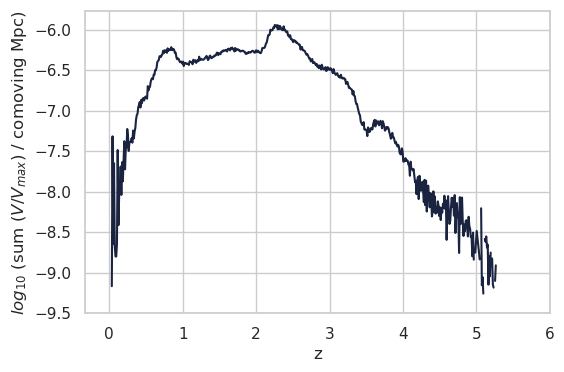

In [25]:
spatial_number_density(sdss_qso_ctlg, z_bin_step=0.01, z_bin_size=0.01, m_max=22.7, sky_coverage=9376, z_max=6)

100%|██████████| 13611/13611 [00:20<00:00, 660.67it/s]
../evaluation.py:497: RuntimeWarning: divide by zero encountered in log10
  sns.lineplot(steps, np.log10(comoving_v_max_densities))


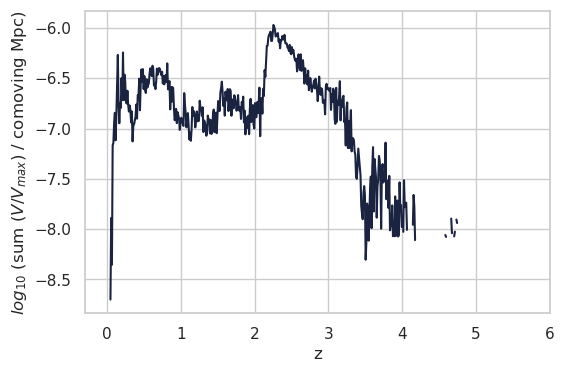

In [26]:
sky_coverage = 1006 * 2 / 3.0
spatial_number_density(kids_x_sdss_qso, z_bin_step=0.01, z_bin_size=0.01, m_max=22.7, sky_coverage=400,
                       z_max=6)

# $V/V_{max}$ test

  2%|▏         | 6893/446135 [00:10<12:22, 591.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 446136/446136 [10:33<00:00, 704.75it/s] 


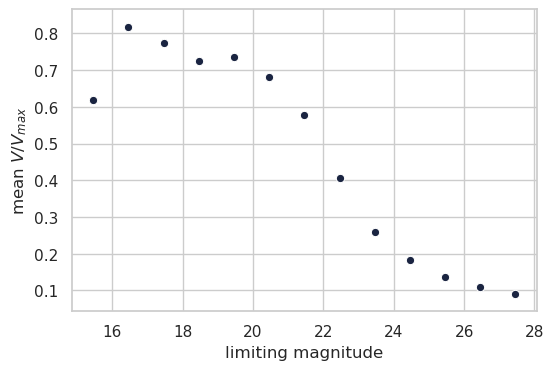

In [24]:
# TODO: Add print on which magnitude does the progress bar relate to
test_v_max(sdss_qso_ctlg['r_PSFMAG'], sdss_qso_ctlg['Z'], step=1)

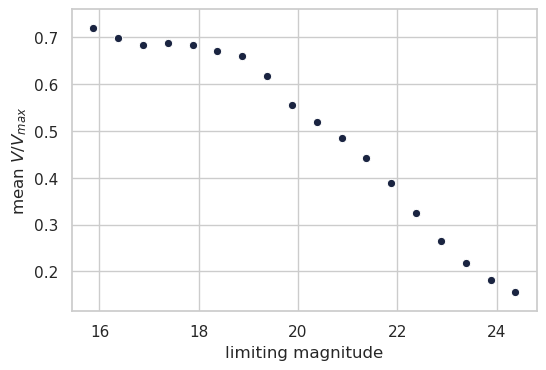

In [33]:
test_v_max(kids_x_sdss_qso[get_mag_str('r')], kids_x_sdss_qso['Z'], step=0.5)